### Import required modules

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu118'

### Create device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


### Create data

In [4]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

#### Split data

In [5]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]


def plot_predictions(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None,
):
    """
    Plots training data, test data, and compares predictions
    """
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Prediction data")

    plt.legend(prop={"size": 14})

    plt.show()

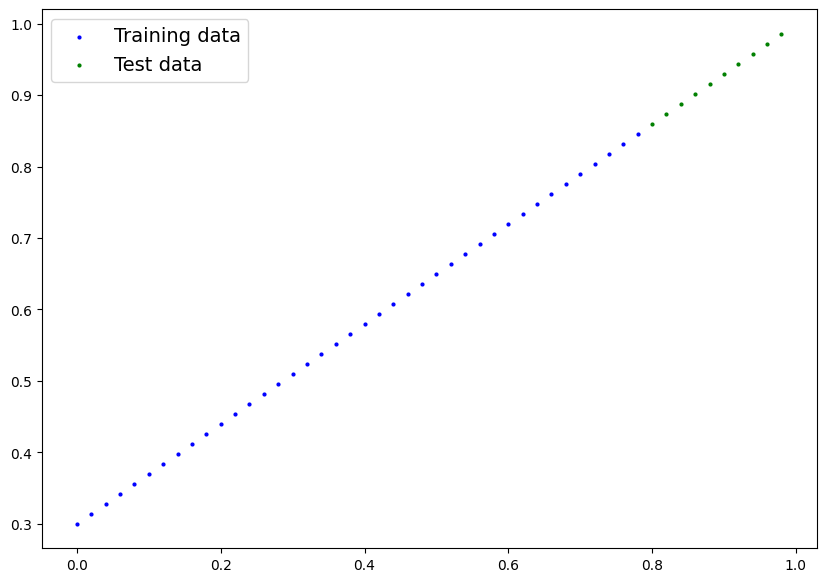

In [6]:
plot_predictions()

### Creating Linear Regression Model

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # use nn.Linear() for model parameters
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

    torch.manual_seed(42)


model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

#### Put model onto gpu

In [8]:
model.to(device=device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [9]:
next(model.parameters()).device
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])

### Training Loop

In [10]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [11]:
torch.manual_seed(42)

epochs = 200

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train)

    # Calculate loss
    loss = loss_fn(predictions, y_train)

    # Zero any accumulated gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # optimizer step
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
        if epoch % 10 == 0:
            print(f"epoch: {epoch} | loss: {loss} | test loss: {test_loss}")

epoch: 0 | loss: 0.5551779866218567 | test loss: 0.5739762187004089
epoch: 10 | loss: 0.439968079328537 | test loss: 0.4392664134502411
epoch: 20 | loss: 0.3247582018375397 | test loss: 0.30455657839775085
epoch: 30 | loss: 0.20954833924770355 | test loss: 0.16984669864177704
epoch: 40 | loss: 0.09433845430612564 | test loss: 0.03513690456748009
epoch: 50 | loss: 0.023886388167738914 | test loss: 0.04784907028079033
epoch: 60 | loss: 0.019956795498728752 | test loss: 0.045803118497133255
epoch: 70 | loss: 0.016517987474799156 | test loss: 0.037530567497015
epoch: 80 | loss: 0.013089174404740334 | test loss: 0.02994490973651409
epoch: 90 | loss: 0.009653178043663502 | test loss: 0.02167237363755703
epoch: 100 | loss: 0.006215683650225401 | test loss: 0.014086711220443249
epoch: 110 | loss: 0.00278724217787385 | test loss: 0.005814164876937866
epoch: 120 | loss: 0.0012645035749301314 | test loss: 0.013801801018416882
epoch: 130 | loss: 0.0012645035749301314 | test loss: 0.013801801018416

In [12]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

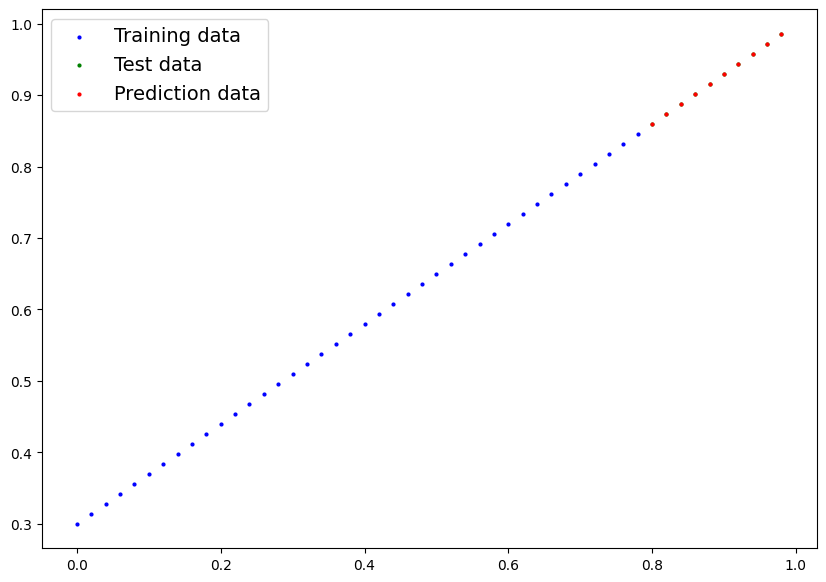

In [14]:
model.eval()
with torch.inference_mode():
    predictions = model(X_test)

plot_predictions(predictions=predictions.cpu())

In [ ]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "workflow_practice_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [19]:
loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model.state_dict(), loaded_model.state_dict()

(OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3025], device='cuda:0'))]),
 OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
              ('linear_layer.bias', tensor([0.3025]))]))